**Aim** : To predict material type to be published based on available features.

Importing necessary packages

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
#from utils import tokenizer
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import ConfusionMatrix
from functools import reduce
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np
import matplotlib.pyplot as plt

Packages specific to text preprocessing

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


def tokenizer(txt):
   ## returns tokenized corpus without stopwords and special characters
    
    ##parameter: 
    ##txt: string
    ps = PorterStemmer()
    lem = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    txt = re.sub('[^A-Za-z\s*]', '', txt.lower())
    tokens = list(filter(lambda x: x not in stop_words and len(x) > 2, word_tokenize(txt)))
    return list([lem.lemmatize(token) for token in tokens]) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shreyasrbhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shreyasrbhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shreyasrbhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Defining data path**

In [4]:
train_path = 'Predictive_Data/train_file.csv'
test_path = 'Predictive_Data/test_file.csv'

**Reading the data and inference**
-  The checkout type, checkout year amd month has same entries for all the records hence dosent contribute in learning patterns for prediction.
- The columns creator, publisher and publication year have aroud 80% null values, so no point in interpolation and thus can be neglected.
-  A large number of checkouts 

(31653, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 12 columns):
ID                 31653 non-null int64
UsageClass         31653 non-null object
CheckoutType       31653 non-null object
CheckoutYear       31653 non-null int64
CheckoutMonth      31653 non-null int64
Checkouts          31653 non-null int64
Title              31653 non-null object
Creator            8516 non-null object
Subjects           29890 non-null object
Publisher          9737 non-null object
PublicationYear    9722 non-null object
MaterialType       31653 non-null object
dtypes: int64(4), object(8)
memory usage: 2.9+ MB
None
                 ID  CheckoutYear  CheckoutMonth     Checkouts
count  31653.000000       31653.0        31653.0  31653.000000
mean   15827.000000        2005.0            4.0      2.117430
std     9137.578372           0.0            0.0      2.629428
min        1.000000        2005.0            4.0      1.000000
25%     7914.000000     

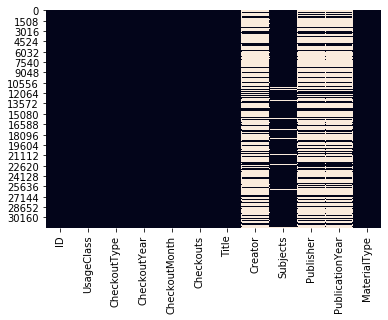

In [5]:
df = pd.read_csv(train_path)
print(df.shape)
print(df.info())
print(df.describe())
df["Publisher"] = pd.Categorical(df["Publisher"])
target = "MaterialType"
features = ["Subjects", "Checkouts"]

df["Subjects"] = pd.Categorical(df["Subjects"])
df["MaterialType"] = pd.Categorical(df["MaterialType"])
id_to_sub = dict(enumerate(df['Subjects'].cat.categories ) )
sub_to_id = {value:key for key, value in id_to_sub.items()}
id_to_mat = dict(enumerate(df['MaterialType'].cat.categories ) )
mat_to_id = {value:key for key, value in id_to_mat.items()}
df["MaterialType"] = df["MaterialType"].map(mat_to_id)
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df[target], random_state = 51)
print(mat_to_id)
print(id_to_mat)
print('\n')
sns.heatmap(df.isnull(), cbar = False)
print(df.UsageClass.value_counts())
print(df.CheckoutYear.value_counts())
print(df.CheckoutMonth.value_counts())

- 90% of checkout are for books, hence adding this feature would overfit the model.
- The only feature left is the subject description which has some potential information on material type.

Text(0.5, 1.0, 'Checkout based on MaterialType')

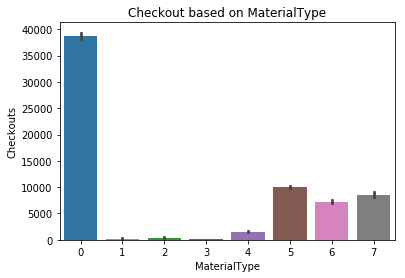

In [74]:
sns.barplot("MaterialType", "Checkouts", data = df, estimator = sum).set_title("Checkout based on MaterialType")

### Removing records for null entries based the the Subject

In [6]:
df_train = df_train.dropna(subset=["Subjects"])

### Check if the words in subjects has some kind of correlation with the MaterialType using the chi2 test.

-  On looking at the unigrams except for the books material others have words in the subject that speaks about the material type

In [0]:
# tfidf = TfidfVectorizer(sublinear_tf=True, tokenizer = tokenizer, min_df=2, max_df = 0.9)
# feature_vec= tfidf.fit_transform(df_train["Subjects"])
cv = CountVectorizer(tokenizer = tokenizer, min_df=1, max_df=0.9)
feature_vec = cv.fit_transform(df_train["Subjects"].values)

In [79]:
N = 15
print("Most correlated unigrams:")
for material, mat_id in mat_to_id.items():
  features_chi2 = chi2(feature_vec, df_train["MaterialType"].values == mat_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(cv.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  print("# '{}':".format(material))
  print("  {}".format(', '.join(unigrams[-N:])))

Most correlated unigrams:
# 'BOOK':
  song, juvenile, jazz, popular, rock, literature, fiction, feature, hearing, impaired, video, recording, drama, film, music
# 'CR':
  lagoon, zion, disneyland, crete, merit, qualifying, scholarship, communal, settlement, collective, cost, estimate, guidebook, directory, periodical
# 'MIXED':
  teaching, caribbean, stravinsky, igor, kindergarten, device, sviashchennaia, idea, vesna, ermitazh, reef, coral, software, multimedia, interactive
# 'MUSIC':
  bass, instruction, guitar, excerpt, sonata, unspecified, piece, arranged, method, part, vocal, edition, simplified, piano, score
# 'SOUNDCASS':
  film, yum, serbia, english, juvenile, galveston, cantonese, england, fictitious, character, language, sound, mystery, speaker, fiction
# 'SOUNDDISC':
  film, juvenile, string, literature, folk, piano, instrumental, sound, orchestra, fiction, song, jazz, rock, popular, music
# 'VIDEOCASS':
  travel, music, description, literature, childrens, comedy, animated, f

- As a first step of model build, generate tfidf vectors from the subject as a feature to the model.
- Select the top hundred words as per their  over all tf-idf values 

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, tokenizer = tokenizer, min_df=2, max_df = 0.7)
feature_vec= tfidf.fit_transform(df_train["Subjects"])

n = 100
top_n_words = np.array(tfidf.get_feature_names())
feature_index = [tfidf.get_feature_names().index(word) for word in list(top_n_words)]
features = np.array(feature_vec.toarray()[:, list(feature_index)])

In [ ]:
models = [
    RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0),
    SVC(),
    LinearSVC(),
    LogisticRegression(random_state=0),
]

scoring = {
           'f1_micro': 'f1_micro',
           'f1_macro': 'f1_macro',
           'weighted': 'f1_weighted'} 


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
wanted_metrics = ["test_f1_micro", "test_f1_macro", "test_weighted"]
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_validate(model, features[:, :50], list(df_train[target].values), scoring=scoring, cv=CV)
    for metric, accuracy in dict(zip(wanted_metrics, [accuracies[k] for k in wanted_metrics])).items():
        for fold_idx, score in enumerate(accuracy):
            entries.append((model_name, fold_idx, metric, score))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'metric', 'score'])
plt.figure(figsize=(10,5))
for i,metric in enumerate(wanted_metrics):
    plt.subplot(1,len(wanted_metrics),i+1)
    sns.boxplot(x='model_name', y='score', data=cv_df[cv_df["metric"] == metric])
    sns.stripplot(x='model_name', y='score', data=cv_df[cv_df["metric"] == metric], 
              size=8, jitter=True, edgecolor="gray", linewidth=2).set_title(metric)
plt.tight_layout()
plt.show()

**Applying Random Forest**

In [17]:
model_1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
model_1.fit(features, df_train[target])

df_test1= df_test.dropna(subset=["Subjects"])
df_test["prediction"] = 0
tfidf_vec_test = tfidf.transform(df_test1["Subjects"].values)
test_features = np.array(tfidf_vec_test.toarray()[:, list(feature_index)])
predictions = model_1.predict(test_features)
df_test.loc[df_test1.index, 'prediction'] = predictions
print(ConfusionMatrix(list(df_test[target]), list(df_test["prediction"])))
print("f1_micro: ",f1_score(df_test[target].values, df_test["prediction"].values, average='micro'))
print("f1_macro: ", f1_score(df_test[target].values, df_test["prediction"].values, average='macro'))
print("f1_weighted: ", f1_score(df_test[target].values, df_test["prediction"].values, average='weighted'))

  |    0    1    2    3    4    5    6    7 |
--+-----------------------------------------+
0 |<4295>   3    .    .    .   27   17    . |
1 |   17   <1>   .    .    .    .    1    . |
2 |   63    .   <5>   .    .    1    .    . |
3 |    3    .    .   <7>   .   22    .    1 |
4 |  188    .    .    .   <.>  13    3    . |
5 |  113    .    .    .    . <714>   2    1 |
6 |  181    .    .    .    .   12 <350>   7 |
7 |   46    .    .    .    .   16  193  <29>|
--+-----------------------------------------+
(row = reference; col = test)

f1_micro:  0.8531037750750277
f1_macro:  0.3977125000284535
f1_weighted:  0.8176663614204647


**Applying SVM**

In [0]:
model_2 = SVC()
model_2.fit(features, df_train[target])

df_test1= df_test.dropna(subset=["Subjects"])
df_test["prediction"] = 0
predictions = model_2.predict(test_features)
df_test.loc[df_test1.index, 'prediction'] = predictions
print(ConfusionMatrix(list(df_test[target]), list(df_test["prediction"])))
print("f1_micro: ",f1_score(df_test[target].values, df_test["prediction"].values, average='micro'))
print("f1_macro: ", f1_score(df_test[target].values, df_test["prediction"].values, average='macro'))

Apply NLTK naive bayes

## Approach
- Generate a universal count vectorizer
- Generate individual count vectorizer for each categories of Material type.
-  Select top words for each categories based on using their individual count vector.
- Remvove the words that are common along the each categories.
- Perform union of all the words across each category and use them as features for naive bayes classification


In [0]:
cv = CountVectorizer(tokenizer = tokenizer, min_df=1, max_df=0.9)
count_vec = cv.fit_transform(df_train["Subjects"].values)

In [0]:
cv0 = CountVectorizer(tokenizer = tokenizer, min_df=5, max_df = 0.8)
count_vec0 = cv0.fit_transform(df_train[df_train[target] == 0]["Subjects"])

cv1 = CountVectorizer(tokenizer = tokenizer, min_df=1, max_df = 0.95)
count_vec1 = cv1.fit_transform(df_train[df_train[target] == 1]["Subjects"])

cv2 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec2 = cv2.fit_transform(df_train[df_train[target] == 2]["Subjects"])

cv3 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec3 = cv3.fit_transform(df_train[df_train[target] == 3]["Subjects"])

cv4 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec4 =  cv4.fit_transform(df_train[df_train[target] == 4]["Subjects"])

cv5 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec5 = cv5.fit_transform(df_train[df_train[target] == 5]["Subjects"])

cv6 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec6 = cv6.fit_transform(df_train[df_train[target] == 6]["Subjects"])

cv7 = CountVectorizer(tokenizer = tokenizer, min_df=2, max_df = 0.95)
count_vec7 = cv7.fit_transform(df_train[df_train[target] == 7]["Subjects"])

In [0]:
words_0 = {word:word_count  for word, word_count in  zip(cv0.get_feature_names(),count_vec0.toarray().sum(axis=0)) }
words_0 = dict(sorted(words_0.items(), key = lambda x: x[1], reverse=True)[:20])
words_0 = set([x[0] for x in words_0.items()])

words_1 = {word:word_count  for word, word_count in  zip(cv1.get_feature_names(),count_vec1.toarray().sum(axis=0)) }
words_1 = dict(sorted(words_1.items(), key = lambda x: x[1], reverse=True)[:100])
words_1 = set([x[0] for x in words_1.items()])

words_2 = {word:word_count  for word, word_count in  zip(cv2.get_feature_names(),count_vec2.toarray().sum(axis=0)) }
words_2 = dict(sorted(words_2.items(), key = lambda x: x[1], reverse=True)[:100])
words_2 = set([x[0] for x in words_2.items()])

words_3 = {word:word_count  for word, word_count in  zip(cv1.get_feature_names(),count_vec3.toarray().sum(axis=0)) }
words_3 = dict(sorted(words_3.items(), key = lambda x: x[1], reverse=True)[:100])
words_3 = set([x[0] for x in words_3.items()])

words_4 = {word:word_count  for word, word_count in  zip(cv4.get_feature_names(),count_vec4.toarray().sum(axis=0)) }
words_4 = dict(sorted(words_4.items(), key = lambda x: x[1], reverse=True)[:1000])
words_4 = set([x[0] for x in words_4.items()])


words_5 = {word:word_count  for word, word_count in  zip(cv5.get_feature_names(),count_vec5.toarray().sum(axis=0)) }
words_5 = dict(sorted(words_5.items(), key = lambda x: x[1], reverse=True)[:100])
words_5 = set([x[0] for x in words_5.items()])

words_6 = {word:word_count  for word, word_count in  zip(cv6.get_feature_names(),count_vec6.toarray().sum(axis=0)) }
words_6 = dict(sorted(words_6.items(), key = lambda x: x[1], reverse=True)[:100])
words_6 = set([x[0] for x in words_6.items()])

words_7 = {word:word_count  for word, word_count in  zip(cv7.get_feature_names(),count_vec7.toarray().sum(axis=0)) }
words_7 = dict(sorted(words_7.items(), key = lambda x: x[1], reverse=True)[:1000])
words_7 = set([x[0] for x in words_7.items()])

top_words = [words_0, words_1, words_2,words_3,words_4,words_5,words_6,words_7 ]

word_features1 = reduce(set.union, top_words) - reduce(set.intersection, top_words)

word_features1 = reduce(set.union, [word_features1]) - reduce(set.intersection, [words_0, words_4])

# word_features1 = reduce(set.union, [word_features1]) - reduce(set.intersection, [words_0, words_7])

#word_features1 = reduce(set.union, [word_features1]) - reduce(set.intersection, [words_0, words_5])
#word_features1 = reduce(set.union, top_words) - reduce(set.intersection, [words_4 - words_0])
# word_features1 = reduce(set.union, [word_features]) - reduce(set.intersection, [words_0, words_5])
# word_features1 = reduce(set.union, top_words) - reduce(set.intersection, [words_0, words_6])



In [0]:
# from itertools import combinations 
# for words1, words2 in combinations(top_words, 2):
#     word_features1 = reduce(set.union, [word_features]) - reduce(set.intersection, [words1, words2])

In [0]:
# word_features.intersection(words_6)

In [0]:
# feature_index = [cv.get_feature_names().index(word) for word in list(word_features1)]
# features = np.array(count_vec.toarray()[:, list(feature_index)])

In [0]:
# model = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=100)
# _ = model.fit(features, list(df_train[target].values))

In [0]:
# model2 = SVC()
# _ = model2.fit(features, list(df_train[target].values))

### Generate input features for naive bayes classification

In [0]:
def extract_features(corpus, features, labels = None):
        ###
        if not(labels is None):
            corpus = [tokenizer(sentence) for sentence, label in zip(corpus, labels)]
            feature_set = [({token: token in tokens for token in features}, label) for tokens, label in zip(corpus, labels)]
        else:
            corpus = [tokenizer(sentence) for sentence in corpus]
            feature_set = [{token: token in tokens for token in features} for tokens in corpus]
        return feature_set

**Extract features and train the classifier**

In [0]:
#words_freq =dict(sorted(words_freq.items(), key = lambda x: x[1], reverse=True)[:1000])
#word_features = [x[0] for x in words_freq.items()]
feature_set = extract_features(df_train["Subjects"], word_features1, labels = df_train[target])
classifier = NaiveBayesClassifier.train(feature_set)

In [54]:
df_test1= df_test.dropna(subset=["Subjects"])
df_test["prediction"] = 0
test_features = extract_features(df_test1["Subjects"].values, word_features1)
predictions = classifier.classify_many(test_features)
df_test.loc[df_test1.index, 'prediction'] = predictions
print(ConfusionMatrix(list(df_test[target]), list(df_test["prediction"])))
print("f1_micro: ",f1_score(df_test[target].values, df_test["prediction"].values, average='micro'))
print("f1_macro: ", f1_score(df_test[target].values, df_test["prediction"].values, average='macro'))
print("f1_weighted: ", f1_score(df_test[target].values, df_test["prediction"].values, average='weighted'))

  |    0    1    2    3    4    5    6    7 |
--+-----------------------------------------+
0 |<4088>   7    .    3  177   54    7    6 |
1 |   18   <.>   .    .    .    .    .    1 |
2 |   64    .   <3>   .    1    1    .    . |
3 |    2    .    .   <3>   .   27    1    . |
4 |  156    1    .    .  <40>   3    4    . |
5 |   95    .    1    4   21 <706>   3    . |
6 |  160    .    1    3    9    9 <296>  72 |
7 |   38    1    1    1    2   15  116 <110>|
--+-----------------------------------------+
(row = reference; col = test)

f1_micro:  0.8286210709208656
f1_macro:  0.4031846360043215
f1_weighted:  0.8188634606527981


Summary.
- Naive bayes classifier performed slighly better on classifying categories with lower samples when compared to random forest and SVM.
- The Naive bayes classifier can be further tuned by varying the number the words for each class .

In [0]:
# df2 = pd.read_csv(test_path)
# df2_new= df2.dropna(subset=["Subjects"])
# df2["pred"] = 0
# count_vec_test = cv.transform(df2_new["Subjects"].values)
# test_features = np.array(count_vec_test.toarray()[:, list(feature_index)])
# predictions = model.predict(test_features)
# df2.loc[df2_new.index, 'pred'] = predictions

In [0]:
# ser = {"ID":df2["ID"].values, 'MaterialType': df2["pred"].values}
# df_pred = pd.DataFrame(ser)
# df_pred["MaterialType"] = df_pred["MaterialType"].map(id_to_mat)
# df_pred.MaterialType.value_counts()
# df_pred.to_csv('submission.csv', index = False)